In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import fastai
fastai.__version__

'1.0.36'

In [3]:
from fastai import *
from fastai_audio import *
from fastai.vision import models

In [4]:
from utils import read_file

In [5]:
DATA = Path('data')
AUDIO = DATA/'freesound/audio_22050_trimmed'
CSV = DATA/'freesound/audio_44KHz/train_with_lens.csv'
TEST_CSV = DATA/'freesound/audio_44KHz/test_with_lens.csv'

In [6]:
df = pd.read_csv(CSV)
if df['fname'].iloc[0].endswith('.wav'):
    df['fname'] = df['fname'].str[:-4]
    df.drop(['manually_verified'], axis=1, inplace=True)

print(df.shape)
df.head(3)

(9473, 3)


,fname,label,n_samples
0,00044347,Hi-hat,617400
1,001ca53d,Saxophone,455112
2,002d256b,Trumpet,19404


In [7]:
test_df = pd.read_csv(TEST_CSV)
test_df.head()

,fname,label,n_samples
0,00063640,Laughter Hi-Hat Flute,69678
1,0013a1db,Laughter Hi-Hat Flute,36162
2,002bb878,Laughter Hi-Hat Flute,59094
3,002d392d,Laughter Hi-Hat Flute,22050
4,00326aa9,Laughter Hi-Hat Flute,91728


In [8]:
n_fft = 2048
n_hop = 512
n_mels = 128
sample_rate = 22050
top_db = 50.0
ref = 1.0

bs = 8

In [9]:
def rand_crop(signal):
    start_pct = 0.1
    end_pct = 0.4
    max_start = signal.shape[0] * start_pct
    max_end = signal.shape[0] * end_pct
    crop_start = int(np.random.rand() * max_start)
    crop_end = int(np.random.rand() * max_end) + 1
    
    s = signal[crop_start:-crop_end]
    if s.shape[0] == 0:
        import pdb; pdb.set_trace()
    return s

In [10]:
def random_stretch(mags, phases):
    pct = 0.2
    a,b = 1.0-pct, 1.0+pct
    r = np.random.rand() * (a - b) + b
    return phase_vocoder(mags, phases, rate=r)

def random_stretch_mags(mags):
    pct = 0.2
    a,b = 1.0-pct, 1.0+pct
    r = np.random.rand() * (a - b) + b
    return phase_vocoder_magnitude(mags, rate=r)

In [11]:
def get_transforms(n_fft=1024, n_hop=256, n_mels=96, sample_rate=16000):
    window = torch.hann_window(n_fft)
    to_db = ToDecibels(power=2, ref=ref, top_db=top_db, normalized=True)
    to_mel = FrequencyToMel(n_mels=n_mels, n_fft=n_fft, sr=sample_rate)
    to_mel.mel_filterbank = to_cpu(to_mel.mel_filterbank)

    def _train_tfm(x):
        if x.shape[0] == 0:
            x = torch.zeros(n_hop * 2)
        x = rand_crop(x)
        X = stft(x, n_fft=n_fft, hop_length=n_hop, window=window)
        power = power_spectrum(X)
        power = random_stretch_mags(power)
        power.unsqueeze_(0)
        mel_power = to_mel(power.transpose(1,2))
        mel_power_db = to_db(mel_power).squeeze_(0)
        return mel_power_db
    
    def _valid_tfm(x):
        if x.shape[0] == 0:
            x = torch.zeros(n_hop * 2)
        X = stft(x, n_fft=n_fft, hop_length=n_hop, window=window)
        power = power_spectrum(X).unsqueeze_(0)
        mel_power = to_mel(power.transpose(1,2))
        mel_power_db = to_db(mel_power).squeeze_(0)
        return mel_power_db
    
    return [_train_tfm],[_valid_tfm]

In [12]:
def add_channel_dim(inputs):
    xs, ys = inputs
    xs.unsqueeze_(1)
    return xs, ys

In [14]:
test_data = AudioItemList.from_df(test_df, path=AUDIO, folder='test', suffix='.wav')

In [15]:
data = (AudioItemList
            .from_df(df, path=AUDIO, folder='train', suffix='.wav')
            .random_split_by_pct()
            .label_from_df()
            .add_test(test_data)
            .transform(get_transforms())
            .databunch(bs=bs, equal_lengths=False, tfms=[add_channel_dim], length_col=2))

In [16]:
# %%time
xs, ys = data.one_batch()
xs.shape, ys.shape, xs.min(), xs.max()

(torch.Size([8, 1, 96, 2448]), torch.Size([8]), tensor(0.), tensor(1.5624))

### resnet18 - 1024 - 256

In [17]:
model_name = 'freesound_22khz-v1'

learn = create_cnn(data, models.resnet18, metrics=[error_rate, mapk])

In [18]:
learn.fit_one_cycle(8)
learn.save(model_name + '-stage-1')

epoch,train_loss,valid_loss,error_rate,mapk
1,2.918675,2.505201,0.649419,0.458641
2,2.511833,2.353058,0.567054,0.533527
3,2.272620,1.998789,0.523759,0.587117
4,2.092140,1.770809,0.454065,0.647307
5,1.955769,1.561659,0.409715,0.678459
6,1.780053,1.476396,0.401795,0.690426
7,1.729633,1.598179,0.403907,0.686906
8,1.665053,1.486797,0.401795,0.690690


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


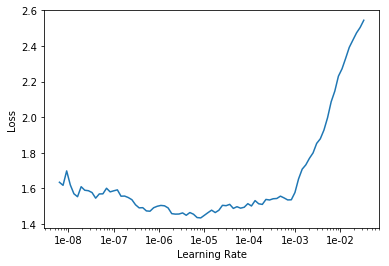

In [22]:
learn.load(model_name + '-stage-1')
learn.unfreeze()
learn.lr_find(start_lr=1e-9, end_lr=1e-1)
learn.recorder.plot()

In [23]:
learn.load(model_name + '-stage-1')
learn.fit_one_cycle(8, max_lr=slice(1e-6,1e-4))
learn.save(model_name + '-stage-2')

epoch,train_loss,valid_loss,error_rate,mapk
1,1.677624,1.405069,0.381732,0.705298
2,1.567116,1.321633,0.352165,0.729849
3,1.651383,1.373302,0.372228,0.712249
4,1.393789,1.227507,0.326294,0.751496
5,1.261258,1.176355,0.317318,0.759328
6,1.233282,1.174101,0.301478,0.770239
7,1.307097,1.163646,0.309398,0.763552
8,1.220540,1.193719,0.309398,0.763728


In [25]:
learn.load(model_name + '-stage-2')
learn.fit_one_cycle(4, max_lr=slice(1e-6,1e-5))
learn.save(model_name + '-stage-3')

epoch,train_loss,valid_loss,error_rate,mapk
1,1.167483,1.146629,0.307286,0.765928
2,1.311664,1.195317,0.317318,0.757392
3,1.220144,1.182616,0.315734,0.760472
4,1.270221,1.135279,0.289863,0.778863


## resnet18 - 1024 - 256

In [ ]:
n_fft = 1024
n_hop = 256
n_mels = 128

data = (AudioItemList
            .from_df(df, path=AUDIO, folder='train', suffix='.wav')
            .random_split_by_pct()
            .label_from_df()
            .add_test(test_data)
           n_hopransform(get_transforms(n_fft=n_fft, n_hop=n_hop, 
                                      n_mels=n_mels, sample_rate=sample_rate))
            .databunch(bs=bs, equal_lengths=False, tfms=[add_channel_dim], length_col=2))

learn = create_cnn(data, models.resnet18, metrics=[error_rate, mapk])
model_name = 'freesound_22khz_1024_256_128_resnet18'
learn.fit_one_cycle(8)
learn.save(model_name + '-stage-1')

## resnet34 - 2048 - 512

In [28]:
n_fft = 2048
n_hop = 512
n_mels = 128

data = (AudioItemList
            .from_df(df, path=AUDIO, folder='train', suffix='.wav')
            .random_split_by_pct()
            .label_from_df()
            .add_test(test_data)
            .transform(get_transforms(n_fft=n_fft, n_hop=n_hop, 
                                      n_mels=n_mels, sample_rate=sample_rate))
            .databunch(bs=bs, equal_lengths=False, tfms=[add_channel_dim], length_col=2))

learn = create_cnn(data, models.resnet34, metrics=[error_rate, mapk])
model_name = 'freesound_22khz_2048_512_128_resnet34'
learn.fit_one_cycle(8)
learn.save(model_name + '-stage-1')

epoch,train_loss,valid_loss,error_rate,mapk
1,2.951504,2.700552,0.714361,0.389563
2,2.627544,2.411612,0.665259,0.436114
3,2.411779,2.155824,0.549102,0.551742
4,2.192558,1.922575,0.511616,0.578669
5,1.921872,1.664389,0.444562,0.655667
6,1.742844,1.491874,0.408131,0.685322
7,1.582598,1.448381,0.387012,0.699490
8,1.659057,1.599523,0.434002,0.658395


## resnet34 - 1024 - 256

In [29]:
n_fft = 1024
n_hop = 256
n_mels = 128

data = (AudioItemList
            .from_df(df, path=AUDIO, folder='train', suffix='.wav')
            .random_split_by_pct()
            .label_from_df()
            .add_test(test_data)
            .transform(get_transforms(n_fft=n_fft, n_hop=n_hop, 
                                      n_mels=n_mels, sample_rate=sample_rate))
            .databunch(bs=bs, equal_lengths=False, tfms=[add_channel_dim], length_col=2))

learn = create_cnn(data, models.resnet34, metrics=[error_rate, mapk])
model_name = 'freesound_22khz_1024_256_128_resnet34'
learn.fit_one_cycle(8)
learn.save(model_name + '-stage-1')

epoch,train_loss,valid_loss,error_rate,mapk
1,2.951219,2.603078,0.666843,0.432946
2,2.495505,2.336603,0.605069,0.504224
3,2.184844,2.015320,0.515312,0.594509
4,2.207912,1.717356,0.452482,0.646075
5,1.696416,1.637689,0.432418,0.665963
6,1.583125,1.474411,0.392819,0.698698
7,1.611961,1.513856,0.404435,0.689018
8,1.609997,1.533215,0.399683,0.692450


## resnet34 - 2048 - 256

In [30]:
n_fft = 2048
n_hop = 256
n_mels = 128

data = (AudioItemList
            .from_df(df, path=AUDIO, folder='train', suffix='.wav')
            .random_split_by_pct()
            .label_from_df()
            .add_test(test_data)
            .transform(get_transforms(n_fft=n_fft, n_hop=n_hop, 
                                      n_mels=n_mels, sample_rate=sample_rate))
            .databunch(bs=bs, equal_lengths=False, tfms=[add_channel_dim], length_col=2))

learn = create_cnn(data, models.resnet34, metrics=[error_rate, mapk])
model_name = 'freesound_22khz_2048_256_128_resnet34'
learn.fit_one_cycle(8)
learn.save(model_name + '-stage-1')

epoch,train_loss,valid_loss,error_rate,mapk
1,2.906033,2.485327,0.648363,0.457937
2,2.554894,2.219502,0.565998,0.539070
3,2.269500,1.816130,0.497888,0.607620
4,2.098107,1.756359,0.485216,0.617916
5,1.827132,1.518036,0.420275,0.679250
6,1.730669,1.426610,0.391763,0.701250
7,1.801798,1.404487,0.375396,0.713745
8,1.582538,1.369801,0.364836,0.722985


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


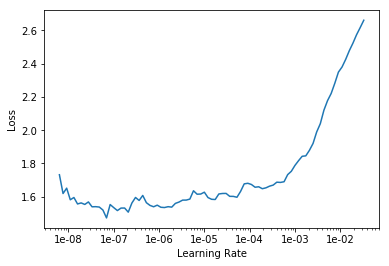

In [31]:
learn.load(model_name + '-stage-1')
learn.unfreeze()
learn.lr_find(start_lr=1e-9, end_lr=1e-1)
learn.recorder.plot()

In [32]:
learn.load(model_name + '-stage-1')
learn.fit_one_cycle(8, max_lr=slice(1e-6,1e-4))
learn.save(model_name + '-stage-2')

epoch,train_loss,valid_loss,error_rate,mapk
1,1.553384,1.315168,0.356389,0.730729
2,1.542918,1.209118,0.328933,0.754136
3,1.460527,1.124898,0.307286,0.769536
4,1.293655,1.057137,0.291975,0.784231
5,1.173551,1.003250,0.269799,0.800071
6,1.047678,1.000445,0.272967,0.794791
7,1.163771,0.974561,0.262936,0.804646
8,1.059619,0.973971,0.258712,0.807990


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


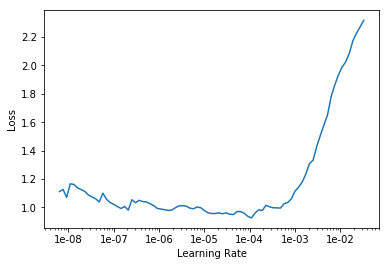

In [33]:
learn.load(model_name + '-stage-2')
learn.unfreeze()
learn.lr_find(start_lr=1e-9, end_lr=1e-1)
learn.recorder.plot()

In [34]:
learn.load(model_name + '-stage-2')
learn.fit_one_cycle(8, max_lr=slice(1e-6,1e-4))
learn.save(model_name + '-stage-3')

epoch,train_loss,valid_loss,error_rate,mapk
1,1.174689,0.973620,0.259240,0.806934
2,1.117773,1.015453,0.264520,0.802886
3,1.081110,0.963240,0.264520,0.802799
4,0.974628,0.900708,0.243400,0.820222
5,0.943679,0.874780,0.235480,0.825678
6,0.870723,0.897746,0.237592,0.820926
7,0.732778,0.861285,0.240232,0.820486
8,0.886630,0.953089,0.260296,0.804822


In [35]:
learn.load(model_name + '-stage-3')
learn.fit_one_cycle(8, max_lr=slice(1e-7,1e-5))
learn.save(model_name + '-stage-4')

epoch,train_loss,valid_loss,error_rate,mapk
1,0.922924,0.866475,0.234425,0.824974
2,0.770003,0.855824,0.229145,0.829902
3,0.728749,0.922856,0.253960,0.810278
4,0.795028,0.833921,0.220697,0.834302
5,0.848252,0.817982,0.227561,0.832718
6,0.719057,0.824199,0.223865,0.834653
7,0.824779,0.924359,0.253960,0.811334
8,0.696125,0.855747,0.228089,0.829022


## Submissions

In [36]:
def save_submission(learner, filename, tta=False):
    fnames = [Path(f).name for f in learn.data.test_ds.x.items]
    get_predsfn = learn.TTA if tta else learn.get_preds
    preds = get_predsfn(ds_type=DatasetType.Test)[0]
    top_3 = np.array(learn.data.classes)[np.argsort(-preds, axis=1)[:, :3]]
    labels = [' '.join(list(x)) for x in top_3]
    df = pd.DataFrame({'fname': fnames, 'label': labels})
    df.to_csv(filename, index=False)
    return df

In [37]:
df1 = save_submission(learn, '22khz_2048_1024.csv', tta=False)

In [38]:
df2 = save_submission(learn, '22khz_2048_1024_tta.csv', tta=True)

### Rerun with ALL the data instead of 80%

In [52]:
n_fft = 2048
n_hop = 256
n_mels = 128

data = (AudioItemList
            .from_df(df, path=AUDIO, folder='train', suffix='.wav')
            .random_split_by_pct(0.0003)
            .label_from_df()
            .add_test(test_data)
            .transform(get_transforms(n_fft=n_fft, n_hop=n_hop, 
                                      n_mels=n_mels, sample_rate=sample_rate))
            .databunch(bs=bs, equal_lengths=False, tfms=[add_channel_dim], length_col=2))

# valid_loss, error_rate, mapk do not mean anything here since validation set only has 2 files
learn = create_cnn(data, models.resnet34, metrics=[error_rate, mapk])
model_name = 'freesound_22khz_2048_256_128_resnet34_all'
learn.fit_one_cycle(8)
learn.save(model_name + '-stage-1')

epoch,train_loss,valid_loss,error_rate,mapk
1,2.708381,1.842100,0.500000,0.500000
2,2.530927,1.962650,0.500000,0.500000
3,2.245543,2.199406,0.500000,0.500000
4,2.018651,2.350728,0.500000,0.500000
5,1.905158,2.896724,0.500000,0.500000
6,1.846546,2.585428,0.500000,0.500000
7,1.627691,2.171052,0.500000,0.500000
8,1.743388,1.992467,0.500000,0.500000


In [ ]:
# learn.fit_one_cycle(8)
# learn.save(model_name + '-stage-1')

In [53]:
learn.load(model_name + '-stage-1')
learn.unfreeze()
learn.fit_one_cycle(8, max_lr=slice(1e-6,1e-4))
learn.save(model_name + '-stage-2')

epoch,train_loss,valid_loss,error_rate,mapk
1,1.532962,1.489428,0.500000,0.500000
2,1.587538,1.806791,0.500000,0.500000
3,1.307515,1.497111,0.500000,0.500000
4,1.228027,1.328031,0.500000,0.500000
5,1.199783,1.456486,0.500000,0.500000
6,1.177433,2.316342,0.500000,0.500000
7,1.081085,1.158355,0.500000,0.500000
8,1.060800,1.305310,0.500000,0.500000


In [54]:
learn.load(model_name + '-stage-2')
learn.fit_one_cycle(8, max_lr=slice(1e-6,1e-4))
learn.save(model_name + '-stage-3')

epoch,train_loss,valid_loss,error_rate,mapk
1,1.068715,2.256703,0.500000,0.500000
2,1.200928,2.092942,0.500000,0.500000
3,1.104527,2.124493,0.500000,0.500000
4,1.006735,2.194441,0.500000,0.500000
5,0.861247,2.047417,0.500000,0.500000
6,0.860661,1.576449,0.500000,0.500000
7,0.759145,2.056094,0.500000,0.500000
8,0.662251,1.990126,0.500000,0.500000


In [55]:
learn.load(model_name + '-stage-3')
learn.fit_one_cycle(8, max_lr=slice(1e-7,1e-5))
learn.save(model_name + '-stage-4')

epoch,train_loss,valid_loss,error_rate,mapk
1,0.840829,1.744894,0.500000,0.500000
2,0.724277,2.375174,0.500000,0.500000
3,0.714209,1.596488,0.500000,0.500000
4,0.792656,1.476703,0.500000,0.500000
5,0.867120,2.163600,0.500000,0.500000
6,0.816310,1.577909,0.500000,0.500000
7,0.744055,2.450953,0.500000,0.500000
8,0.707859,2.115097,0.500000,0.500000


In [56]:
df1 = save_submission(learn, '22khz_2048_256_128_all.csv', tta=False)

In [57]:
df2 = save_submission(learn, '22khz_2048_256_128_all_tta.csv', tta=True)

### Tests with just STFT

In [ ]:
# def get_transforms_no_mel(n_fft=1024, n_hop=256, n_mels=96, sample_rate=16000):
#     window = torch.hann_window(n_fft)
#     to_db = ToDecibels(power=2, ref=ref, top_db=top_db, normalized=True)

#     def _train_tfm(x):
#         if x.shape[0] == 0:
#             x = torch.zeros(n_hop * 2)
#         x = rand_crop(x)
#         X = stft(x, n_fft=n_fft, hop_length=n_hop, window=window)
#         power = power_spectrum(X)
#         power = random_stretch_mags(power)
#         power.unsqueeze_(0)
#         mel_power = to_mel(power.transpose(1,2))
#         power_db = to_db(mel_power).squeeze_(0)
#         return mel_power_db
    
#     def _valid_tfm(x):
#         if x.shape[0] == 0:
#             x = torch.zeros(n_hop * 2)
#         X = stft(x, n_fft=n_fft, hop_length=n_hop, window=window)
#         power = power_spectrum(X).unsqueeze_(0)
#         mel_power = to_mel(power.transpose(1,2))
#         mel_power_db = to_db(mel_power).squeeze_(0)
#         return mel_power_db
    
#     return [_train_tfm],[_valid_tfm]